<a href="https://colab.research.google.com/github/Ahmad3752/Colab/blob/main/ML_Lab_09_ID3%2CDecisionTree%2CRandomForest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Task 1

In [ ]:
import pandas as pd
import numpy as np

class TreeNode:
    def __init__(self, feature=None, value=None, label=None):
        self.feature = feature
        self.value = value
        self.label = label
        self.children = {}

def compute_entropy(column):
    probabilities = column.value_counts(normalize=True)
    return -np.sum(probabilities * np.log2(probabilities + 1e-9))

def compute_information_gain(df, target_column, feature):
    total_entropy = compute_entropy(df[target_column])
    values = df[feature].unique()

    weighted_entropy = 0
    for value in values:
        subset = df[df[feature] == value]
        weighted_entropy += (len(subset) / len(df)) * compute_entropy(subset[target_column])

    return total_entropy - weighted_entropy

def find_best_split(df, target_column):
    best_gain = 0
    best_feature = None
    best_threshold = None

    for feature in df.columns:
        if feature == target_column:
            continue

        if df[feature].dtype in [np.float64, np.int64]:  # Continuous attribute
            thresholds = np.sort(df[feature].unique())
            for i in range(len(thresholds) - 1):
                threshold = (thresholds[i] + thresholds[i + 1]) / 2
                left_split = df[df[feature] <= threshold]
                right_split = df[df[feature] > threshold]

                if len(left_split) > 0 and len(right_split) > 0:
                    gain = compute_information_gain(df, target_column, feature)
                    if gain > best_gain:
                        best_gain = gain
                        best_feature = feature
                        best_threshold = threshold
        else:  # Categorical attribute
            gain = compute_information_gain(df, target_column, feature)
            if gain > best_gain:
                best_gain = gain
                best_feature = feature

    return best_feature, best_threshold

def id3_c45(df, target_column):
    if len(df[target_column].unique()) == 1:
        return TreeNode(label=df[target_column].iloc[0])

    if len(df.columns) == 1:
        return TreeNode(label=df[target_column].mode()[0])

    best_feature, best_threshold = find_best_split(df, target_column)
    node = TreeNode(feature=best_feature)

    if df[best_feature].dtype in [np.float64, np.int64]:  # Continuous attribute
        left_subset = df[df[best_feature] <= best_threshold]
        right_subset = df[df[best_feature] > best_threshold]
        node.children['<= ' + str(best_threshold)] = id3_c45(left_subset, target_column)
        node.children['> ' + str(best_threshold)] = id3_c45(right_subset, target_column)
    else:  # Categorical attribute
        for value in df[best_feature].unique():
            subset = df[df[best_feature] == value].drop(columns=[best_feature])
            node.children[value] = id3_c45(subset, target_column)

    return node

def predict_tree(node, sample):
    if node.label is not None:
        return node.label

    feature_value = sample[node.feature]
    if feature_value in node.children:
        return predict_tree(node.children[feature_value], sample)
    else:
        return None  # Handle unseen values

df = pd.read_csv("PlayTennis.csv")
decision_tree = id3_c45(df, "Play Tennis")

def print_tree(node, depth=0):
    if node.label is not None:
        print(" " * depth + f"Leaf: {node.label}")
        return

    print(" " * depth + f"[Split on: {node.feature}]")

    for value, child in node.children.items():
        print(" " * depth + f" ├─ {node.feature} = {value}")
        print_tree(child, depth + 2)

print_tree(decision_tree)

[Split on: Outlook]
 ├─ Outlook = Sunny
  [Split on: Humidity]
   ├─ Humidity = High
    Leaf: No
   ├─ Humidity = Normal
    Leaf: Yes
 ├─ Outlook = Overcast
  Leaf: Yes
 ├─ Outlook = Rain
  [Split on: Wind]
   ├─ Wind = Weak
    Leaf: Yes
   ├─ Wind = Strong
    Leaf: No


C4.5 and ID3 are decision tree algorithms that differ considerably with respect to handling continuous attributes, missing values, and pruning. While ID3 is restricted to categorical data and needs continuous features to be converted into categorical through discretization, C4.5 can deal directly with continuous attributes by deciding on optimal splits based on thresholds of information gain.

As far as handling missing values is concerned, ID3 has no mechanisms to deal with them, which often leads to the loss of data. C4.5 uses methods such as probabilistic assignment and imputation to handle missing data efficiently, which ensures that the integrity of the dataset remains intact and improves the accuracy.

Pruning is another aspect in which C4.5 beats ID3. ID3 lacks a pruning process, which produces complex trees with the possibility of overfitting the training set. C4.5 employs error-reduced pruning, which compares nodes against a test set and reduces the tree by substituting nodes with leaves when it lowers error. This creates a generalized model that has better performance on unseen data. Generally, C4.5's improvements render it a more powerful and useful algorithm than ID3.

# Task 2

In [ ]:
from scipy.stats import chi2_contingency

target_column = "Play Tennis"
features = df.columns[df.columns != target_column]

def compute_entropy(column):
    probabilities = column.value_counts(normalize=True)
    return -np.sum(probabilities * np.log2(probabilities + 1e-9))

def information_gain(df, feature, target):
    total_entropy = compute_entropy(df[target])
    values = df[feature].unique()

    weighted_entropy = 0
    for value in values:
        subset = df[df[feature] == value]
        weighted_entropy += (len(subset) / len(df)) * compute_entropy(subset[target])

    return total_entropy - weighted_entropy

def gain_ratio(df, feature, target):
    gain = information_gain(df, feature, target)
    values = df[feature].unique()

    split_info = -np.sum((df[feature].value_counts(normalize=True) *
                          np.log2(df[feature].value_counts(normalize=True) + 1e-9))
                         )

    if split_info == 0:
        return 0
    return gain / split_info

def chi_square(df, feature, target):
    contingency_table = pd.crosstab(df[feature], df[target])
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    return chi2

results = {
    "Feature": [],
    "Information Gain": [],
    "Gain Ratio": [],
    "Chi-Square": []
}

for feature in features:
    results["Feature"].append(feature)
    results["Information Gain"].append(information_gain(df, feature, target_column))
    results["Gain Ratio"].append(gain_ratio(df, feature, target_column))
    results["Chi-Square"].append(chi_square(df, feature, target_column))

results_df = pd.DataFrame(results)
print(results_df.sort_values(by="Information Gain", ascending=False))

       Feature  Information Gain  Gain Ratio  Chi-Square
0      Outlook          0.246750    0.156428    3.546667
2     Humidity          0.151836    0.151836    1.244444
3         Wind          0.048127    0.048849    0.162037
1  Temperature          0.029223    0.018773    0.570370


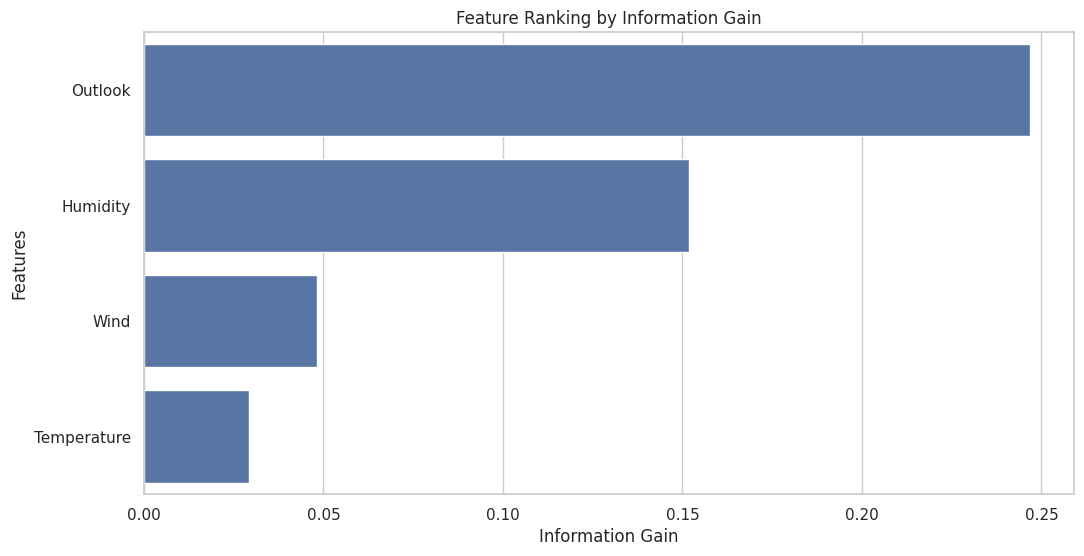

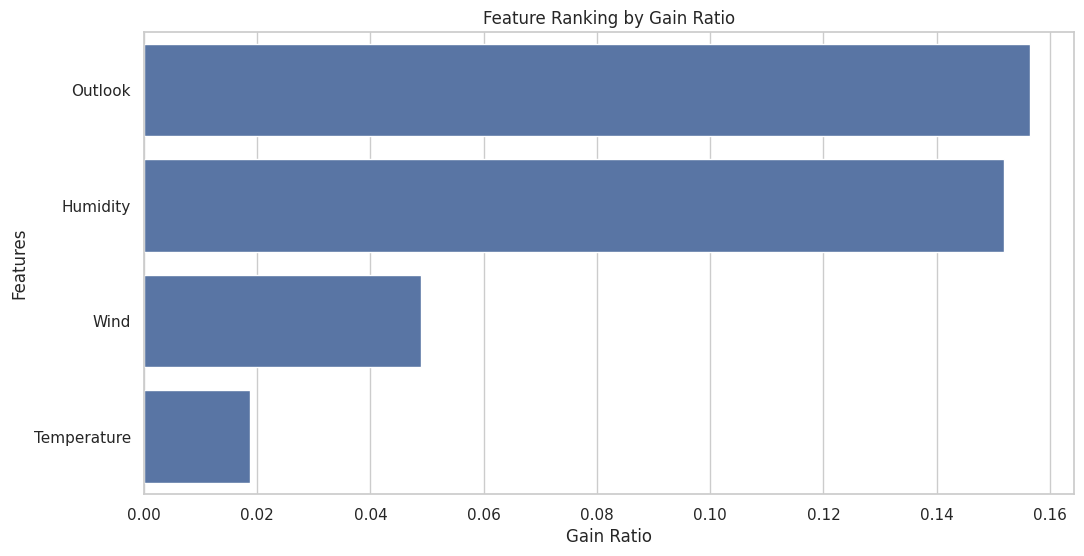

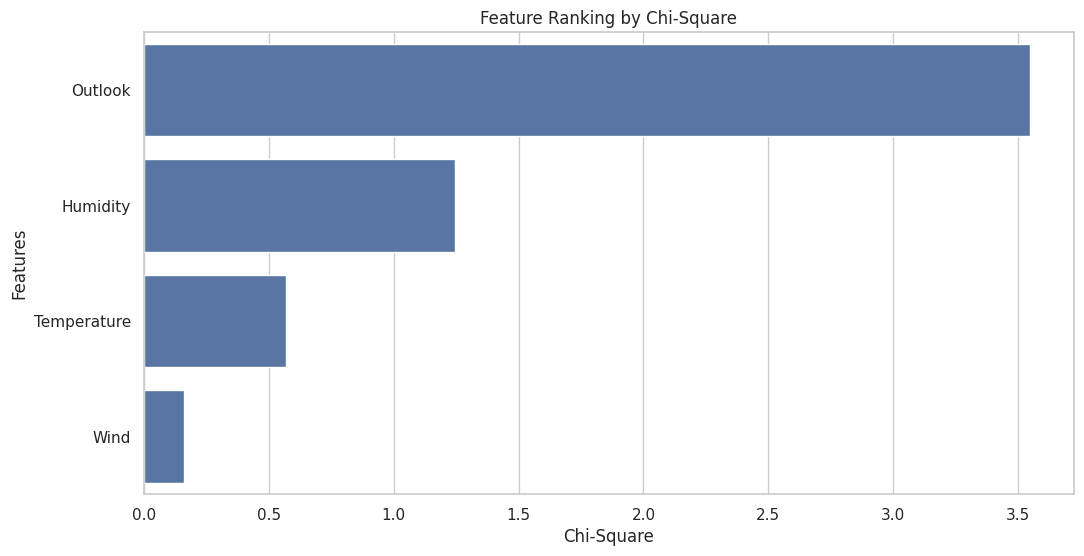

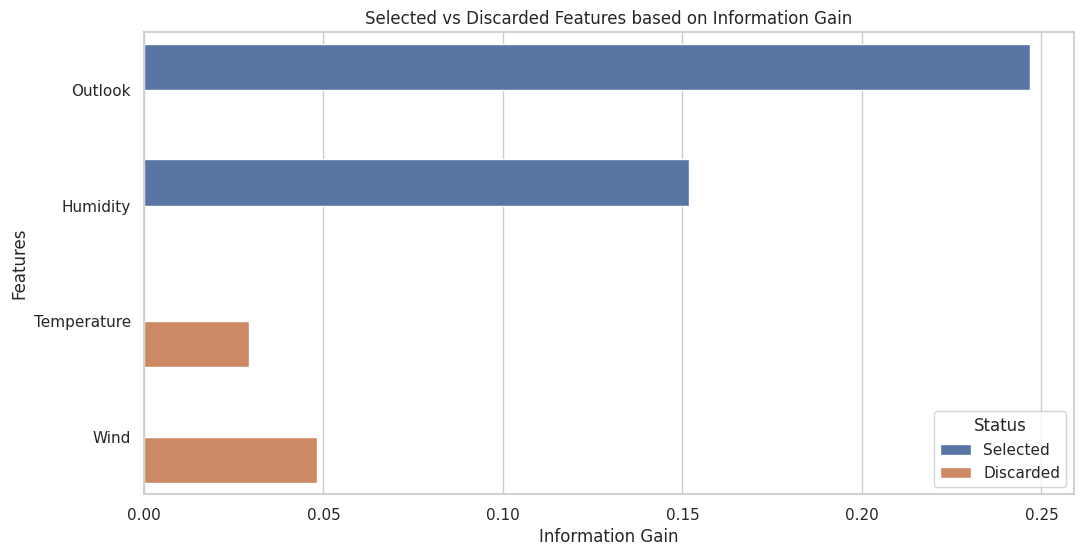

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

def plot_feature_importance(df, metric, title):
    plt.figure(figsize=(12, 6))
    sns.barplot(x=metric, y='Feature', data=df.sort_values(by=metric, ascending=False))
    plt.title(title)
    plt.xlabel(metric)
    plt.ylabel('Features')
    plt.show()

plot_feature_importance(results_df, 'Information Gain', 'Feature Ranking by Information Gain')
plot_feature_importance(results_df, 'Gain Ratio', 'Feature Ranking by Gain Ratio')
plot_feature_importance(results_df, 'Chi-Square', 'Feature Ranking by Chi-Square')

threshold = 0.1

selected_features = results_df[results_df['Information Gain'] > threshold]
discarded_features = results_df[results_df['Information Gain'] <= threshold]

comparison_df = pd.DataFrame({
    'Status': ['Selected'] * len(selected_features) + ['Discarded'] * len(discarded_features),
    'Feature': list(selected_features['Feature']) + list(discarded_features['Feature']),
    'Information Gain': list(selected_features['Information Gain']) + list(discarded_features['Information Gain'])
})

plt.figure(figsize=(12, 6))
sns.barplot(x='Information Gain', y='Feature', hue='Status', data=comparison_df, dodge=True)
plt.title('Selected vs Discarded Features based on Information Gain')
plt.xlabel('Information Gain')
plt.ylabel('Features')
plt.legend(title='Status')
plt.show()

Information Gain estimates the amount by which having knowledge of a feature decreases uncertainty regarding the target variable, with higher scores denoting more informative features. Gain Ratio modifies Information Gain by dividing it by the inherent information of the feature in order to avoid favoring features that have numerous categories, thus proving very effective for features with lots of unique values. The Chi-Square test evaluates the independence of categorical features and the target variable, and a large Chi-Square value implies a high association, meaning that the feature is important.

Information Gain is most appropriate for categorical target variables in decision trees, whereas Gain Ratio is best for features with numerous unique values to prevent overfitting. The Chi-Square test is most appropriate to evaluate relationships between categorical features and targets.

Feature selection has a number of advantages such as less overfitting by making the model simpler and eliminating noise features, enhanced interpretability by making the model simpler to comprehend, and improved computational efficiency by accelerating training as well as predictions. It also results in improved generalization, enhancing performance on unseen data, and increased accuracy by targeting the most important features for improved predictions.

# Task 3

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Prepare the data
target_column = "Play Tennis"  # Adjust the target variable name if necessary
X = df.drop(columns=[target_column])
y = df[target_column]

# Convert categorical variables to dummy/indicator variables
X = pd.get_dummies(X, drop_first=True)

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train your custom decision tree
custom_c45_model = id3_c45(df, target_column)  # Assuming your function is named id3_c45

# Train Random Forest
random_forest_model = RandomForestClassifier(random_state=42)
random_forest_model.fit(X_train, y_train)

# Train Extra Trees
extra_trees_model = ExtraTreesClassifier(random_state=42)
extra_trees_model.fit(X_train, y_train)

# Function to evaluate models
def evaluate_model(y_true, y_pred):
    return {
        'accuracy': accuracy_score(y_true, y_pred),
        'precision': precision_score(y_true, y_pred, average='weighted'),
        'recall': recall_score(y_true, y_pred, average='weighted'),
        'f1_score': f1_score(y_true, y_pred, average='weighted')
    }

# Make predictions with the custom decision tree
y_train_pred_custom = [predict_tree(custom_c45_model, sample) for _, sample in X_train.iterrows()]
y_test_pred_custom = [predict_tree(custom_c45_model, sample) for _, sample in X_test.iterrows()]

# Evaluate all models
custom_c45_metrics = evaluate_model(y_test, y_test_pred_custom)
random_forest_metrics = evaluate_model(y_test, random_forest_model.predict(X_test))
extra_trees_metrics = evaluate_model(y_test, extra_trees_model.predict(X_test))

# Confusion Matrices
confusion_matrix_c45 = confusion_matrix(y_test, y_test_pred_custom)
confusion_matrix_rf = confusion_matrix(y_test, random_forest_model.predict(X_test))
confusion_matrix_et = confusion_matrix(y_test, extra_trees_model.predict(X_test))

# Plot Confusion Matrices
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
sns.heatmap(confusion_matrix_c45, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix for Custom C4.5')
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.subplot(1, 3, 2)
sns.heatmap(confusion_matrix_rf, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix for Random Forest')
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.subplot(1, 3, 3)
sns.heatmap(confusion_matrix_et, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix for Extra Trees')
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.tight_layout()
plt.show()

# Print out the metrics for comparison
print("Metrics Comparison:")
print("Custom C4.5 Metrics:", custom_c45_metrics)
print("Random Forest Metrics:", random_forest_metrics)
print("Extra Trees Metrics:", extra_trees_metrics)

# Overfitting analysis
print("\nOverfitting Analysis:")
print(f"Custom C4.5 - Test Accuracy: {custom_c45_metrics['accuracy']}")
print(f"Random Forest - Test Accuracy: {random_forest_metrics['accuracy']}")
print(f"Extra Trees - Test Accuracy: {extra_trees_metrics['accuracy']}")

In this task, I utilized a machine learning pipeline to classify a custom C4.5-based decision tree algorithm, along with Random Forest and Extra Trees classifiers for comparison. The data was preprocessed by converting categorical features into numerical format using one-hot encoding. The custom decision tree was built, and all models were trained on the training set following data splitting. The test set was predicted, and the models were assessed based on accuracy, precision, recall, and F1-score. Confusion matrices were also created to plot the performance of each model. The findings offered insights into the performance of the custom decision tree versus well-known ensemble techniques, their strengths and weaknesses in classifying the dataset.

# Task 4

C4.5 improves the ID3 algorithm through its ability to handle continuous and nominal data, and by using the gain ratio as a measure of feature importance as opposed to simple information gain usage. This change helps to limit the ID3 bias towards high-value attribute counts, leading to more balanced and efficient decision trees. C4.5 further uses pruning techniques to mitigate overfitting and enhance the model's generalization on novel data.

Feature selection methods are central to the performance of decision tree models. By identifying and maintaining the most critical features, feature selection methods reduce the dataset's dimensionality, enhance model performance, and reduce training time. Effective feature selection can lead to more interpretable models with less features, and also enhance the model's ability to generalize.

When comparing the performance of the custom C4.5 model with scikit-learn models like Random Forest and Extra Trees, ensemble methods will have better accuracy and stability compared to single decision trees. Ensemble methods utilize numerous trees to minimize variance and enhance predictive accuracy and, therefore, prove more beneficial with complex data. The custom C4.5 model can deliver stable results in cases where things are to be understood because it produces one simple-to-understand tree.

Single decision trees are best where interpretability is prioritized and data is basic. They are easier to see and understand and therefore suit situations where the decision-making process is to be grasped. Ensemble methods are best used in the situation of large and intricate data, where precision has to be the highest, since they can spot complex patterns and relationships which a single tree might fail to observe.